<a href="https://colab.research.google.com/github/CamiloVga/Curso-IA-Aplicada/blob/main/Script_20_RNN_para_An%C3%A1lisis_de_Sentimiento.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🤖 Inteligencia Artificial Aplicada para la Economía
## Universidad de los Andes

### 👨‍🏫 Profesores
- **Profesor Magistral:** [Camilo Vega Barbosa](https://www.linkedin.com/in/camilovegabarbosa/)
- **Asistente de Docencia:** [Sergio Julian Zona Moreno](https://www.linkedin.com/in/sergiozonamoreno/)

### 📚 Análisis de Sentimiento con RNN para Tweets Financieros
Este notebook implementa Redes Neuronales Recurrentes (RNN) para análisis de sentimiento en tweets financieros, utilizando el dataset **TimKoornstra/financial-tweets-sentiment**:

1. **Preprocesamiento de Texto para Tweets Financieros 🧹**
   - Limpieza y normalización de tweets del sector financiero
   - Tokenización adaptada para texto de redes sociales
   - Manejo de vocabulario especializado en finanzas y mercados

2. **Arquitecturas RNN Avanzadas 🧠**
   - Simple RNN: Fundamentos de procesamiento secuencial
   - LSTM: Manejo de dependencias a largo plazo
   - GRU: Optimización computacional con rendimiento comparable
   - Redes Bidireccionales: Captura de contexto completo

3. **Embeddings Semánticos 🔤**
   - Embeddings tradicionales vs. BERT
   - Transferencia de conocimiento desde modelos preentrenados
   - Representación contextual de términos financieros y bursátiles

4. **Optimización de Hiperparámetros 📊**
   - Grid Search exhaustivo
   - Evaluación comparativa de arquitecturas
   - Métricas especializadas para clasificación de sentimiento
   - Visualización de resultados experimentales

In [1]:
#####################################################################
# SECCIÓN 1: INSTALACIÓN DE LIBRERÍAS Y CONFIGURACIÓN INICIAL
#####################################################################

# Instalación de paquetes necesarios
!pip install transformers datasets tensorflow nltk scikit-learn matplotlib pandas -q

# Importaciones principales organizadas por categoría
# --- Análisis de datos y visualización ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- Procesamiento de lenguaje natural ---
import re
import nltk
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from transformers import BertTokenizer, TFBertModel

# --- Modelos de Deep Learning ---
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, LSTM, GRU, SimpleRNN, Bidirectional
from tensorflow.keras.layers import Embedding, GlobalMaxPooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# --- Evaluación de modelos ---
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

# --- Otros utilitarios ---
from datasets import load_dataset
import time
import itertools

# Descarga recursos de NLTK necesarios
nltk.download('punkt', quiet=True)

# Configurar semilla aleatoria para reproducibilidad
# Esto asegura que los resultados sean consistentes en múltiples ejecuciones
np.random.seed(42)
tf.random.set_seed(42)



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 487.4/487.4 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 7.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-cupti-cu12 12.5.82 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-nvrtc-cu12==12.

## Base de Datos y preprocesamiento


**Este bloque de código** se encarga del preprocesamiento de la **base de datos TimKoornstra/financial-tweets-sentiment**, que contiene tweets clasificados según su sentimiento sobre temas financieros: **positivo (1), negativo (2) o neutral (0)**.

La sección comienza cargando el dataset "**TimKoornstra/financial-tweets-sentiment**", que es una colección integral de tweets enfocados en temas financieros, meticulosamente curada para análisis de sentimiento en el dominio de finanzas y mercados bursátiles.

El código realiza una **exploración inicial de los datos**, verificando la distribución de las clases en el dataset original: 17,368 sentimientos alcistas (bullish), 8,542 bajistas (bearish) y 12,181 neutrales.

A continuación, aplica **técnicas especializadas de preprocesamiento para tweets**: conversión a minúsculas, eliminación de menciones (@usuario), enlaces, hashtags, caracteres especiales, y normalización de espacios. También realiza tokenización adaptada para el lenguaje típico de Twitter.

Los datos se dividen en **conjuntos de entrenamiento (80%) y prueba (20%)**, manteniendo la distribución de las clases mediante estratificación para asegurar representatividad en ambos conjuntos.

Finalmente, realiza la **tokenización de los textos** y carga un **modelo BERT preentrenado** para generar embeddings avanzados. Estos embeddings proporcionan **representaciones vectoriales ricas en contexto** para términos financieros específicos, permitiendo que las redes neuronales recurrentes capturen mejor los matices del sentimiento expresado en los tweets sobre mercados financieros.


In [2]:
#####################################################################
# SECCIÓN 2: PREPROCESAMIENTO DE LA BASE DE DATOS
#####################################################################

print("Cargando dataset de tweets financieros...")

try:
    # Cargamos el dataset TimKoornstra/financial-tweets-sentiment
    dataset = load_dataset("TimKoornstra/financial-tweets-sentiment",
                         split="train",
                         trust_remote_code=True)

    # Convertir a DataFrame
    df = pd.DataFrame(dataset)

    # Verificamos las columnas del dataset
    print(f"Columnas en el dataset: {df.columns.tolist()}")

    # Renombramos columnas para coincidir con el dataset real (nombres en minúsculas)
    if 'tweet' in df.columns:
        df.rename(columns={'tweet': 'text'}, inplace=True)
    if 'sentiment' in df.columns:
        df.rename(columns={'sentiment': 'label'}, inplace=True)

    # Limitamos a una muestra estratificada
    # Verificar distribución original
    class_distribution = df['label'].value_counts()
    print("\nDistribución original de clases:")
    print(class_distribution)

    # Muestreo estratificado asegurando mínimo 2 muestras por clase
    sample_size = min(3333, class_distribution.min())  # Ajustar según disponibilidad
    df = df.groupby('label', group_keys=False).apply(
        lambda x: x.sample(n=max(2, min(len(x), sample_size)), random_state=42)  # Mínimo 2 muestras por clase
    ).reset_index(drop=True)

    # Verificar nueva distribución
    new_class_distribution = df['label'].value_counts()
    print("\nDistribución después del muestreo:")
    print(new_class_distribution)

    # Validación crítica: cada clase debe tener al menos 2 muestras
    if (new_class_distribution < 2).any():
        raise ValueError(f"Clase con menos de 2 muestras: {new_class_distribution}")

except Exception as e:
    print(f"Error al cargar el dataset: {e}")
    print("Creando datos de ejemplo como último recurso...")
    # Datos mínimos de ejemplo mejorados
    texts = [
        "$AAPL looking bullish today, great earnings report!",
        "$TSLA down 5% after disappointing delivery numbers",
        "Markets steady as Fed maintains current policy stance",
        "Positive outlook for $GOOGL after AI conference",
        "$AMZN faces regulatory challenges in EU markets",
        "Oil prices volatile amid Middle East tensions"
    ]
    labels = [1, 2, 0, 1, 2, 0]  # Duplicamos muestras por clase
    df = pd.DataFrame({"text": texts, "label": labels})

# Exploración básica del dataset
print("\nInformación del dataset:")
print(f"Número de ejemplos: {len(df)}")
print(f"Distribución de clases: {df['label'].value_counts().to_dict()}")

# Validación final para train_test_split
class_dist = df['label'].value_counts()
if (class_dist < 2).any():
    raise ValueError(f"No hay suficientes muestras para división estratificada. Distribución: {class_dist}")

print("\nPrimeras filas del dataset:")
print(df.head())

# Preprocesamiento de texto especializado para tweets financieros
print("\nPreparando los datos...")

def preprocess_tweet(text):
    """
    Función especializada para preprocesar tweets financieros
    - Elimina menciones, URLs, hashtags
    - Preserva símbolos de empresas ($AAPL, $MSFT, etc.)
    - Normaliza el texto
    """
    # Verificar tipo de dato
    if not isinstance(text, str):
        text = str(text)

    # Convertir a minúsculas
    text = text.lower()

    # Eliminar URLs
    text = re.sub(r'https?://\S+|www\.\S+', '', text)

    # Eliminar menciones (@usuario)
    text = re.sub(r'@\w+', '', text)

    # Preservar símbolos de acciones ($AAPL)
    stock_symbols = re.findall(r'\$[A-Za-z]+', text)

    # Eliminar caracteres especiales pero mantener letras, números y espacios
    text = re.sub(r'[^a-zA-Z0-9\s\$]', ' ', text)  # Mantener símbolos de dólar

    # Reintroducir los símbolos de acciones
    for symbol in stock_symbols:
        text = text + ' ' + symbol.lower()

    # Eliminar espacios múltiples
    text = re.sub(r'\s+', ' ', text).strip()

    return text

# Aplicar preprocesamiento
df['processed_text'] = df['text'].apply(preprocess_tweet)

# Separar datos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    df['processed_text'],
    df['label'],
    test_size=0.2,
    random_state=42,
    stratify=df['label']
)

print(f"\nTamaño conjunto entrenamiento: {len(X_train)}")
print(f"Tamaño conjunto prueba: {len(X_test)}")

# Tokenización usando TensorFlow
print("\nTokenizando textos...")

# Parámetros de tokenización
max_words = 15000  # Aumentamos el vocabulario para capturar términos financieros
max_len = 50       # Longitud máxima ajustada para tweets (típicamente cortos)

# El tokenizador convierte palabras en números (índices)
tokenizer = Tokenizer(num_words=max_words, oov_token='<OOV>')  # OOV = Out Of Vocabulary
tokenizer.fit_on_texts(X_train)  # Aprende el vocabulario del conjunto de entrenamiento

# Convertir textos a secuencias de índices
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Padding: hacer que todas las secuencias tengan la misma longitud
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post')

# Tamaño real del vocabulario (limitado por max_words)
vocab_size = min(max_words, len(tokenizer.word_index)) + 1
print(f"Tamaño del vocabulario: {vocab_size} palabras únicas")

# Cargar BERT para embeddings
print("\nCargando modelo BERT para embeddings...")

# Usamos el modelo BERT base, que tiene buen rendimiento para inglés general
bert_model = TFBertModel.from_pretrained('bert-base-uncased')
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def get_bert_embeddings(tokenizer, bert_tokenizer, bert_model, vocab_size=15000, embedding_dim=768):
    print("Generando embeddings BERT para el vocabulario financiero...")
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    # Limitamos a las 300 palabras más frecuentes para ahorrar tiempo
    # En un escenario real, se procesaría todo el vocabulario
    words = []
    for word, idx in tokenizer.word_index.items():
        if idx < 300:  # Aumentamos el número de palabras para capturar más términos financieros
            words.append(word)

    # Calcular embeddings para cada palabra
    for word in words:
        idx = tokenizer.word_index[word]
        if idx >= vocab_size:
            continue

        # Tokenizar la palabra con BERT
        bert_tokens = bert_tokenizer(word, return_tensors='tf')

        # Obtener salida del modelo BERT
        outputs = bert_model(bert_tokens)

        # Usar la representación del token
        word_embedding = outputs.last_hidden_state.numpy()[:, 1, :]
        embedding_matrix[idx] = word_embedding

    print(f"Embeddings BERT generados para {len(words)} palabras")
    return embedding_matrix

# Obtener matriz de embeddings BERT
bert_embedding_matrix = get_bert_embeddings(
    tokenizer,
    bert_tokenizer,
    bert_model,
    vocab_size=vocab_size
)

Cargando dataset de tweets financieros...


README.md:   0%|          | 0.00/4.21k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/2.65M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/38091 [00:00<?, ? examples/s]

Columnas en el dataset: ['tweet', 'sentiment', 'url']

Distribución original de clases:
label
1    17368
0    12181
2     8542
Name: count, dtype: int64

Distribución después del muestreo:
label
0    3333
1    3333
2    3333
Name: count, dtype: int64

Información del dataset:
Número de ejemplos: 9999
Distribución de clases: {0: 3333, 1: 3333, 2: 3333}

Primeras filas del dataset:
                                                text  label  \
0  Edited Transcript of MFA earnings conference c...      0   
1  German Federal President Steinmeier today awar...      0   
2  Coronavirus Threat Looms Over Fragile African ...      0   
3  $TTCM #NFT https://t.co/ncmCLAbNi9 https://t.c...      0   
4  $FLOW $APO - Apollo near deal to buy SPX Flow ...      0   

                                                 url  
0  https://huggingface.co/datasets/zeroshot/twitt...  
1  https://huggingface.co/datasets/zeroshot/twitt...  
2  https://huggingface.co/datasets/zeroshot/twitt...  
3  https://www.kag

<ipython-input-2-1a599e9363d9>:33: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('label', group_keys=False).apply(



Tamaño conjunto entrenamiento: 7999
Tamaño conjunto prueba: 2000

Tokenizando textos...
Tamaño del vocabulario: 15001 palabras únicas

Cargando modelo BERT para embeddings...


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Generando embeddings BERT para el vocabulario financiero...
Embeddings BERT generados para 299 palabras



=== MUESTRA DE DATOS LIMPIOS ===
Texto original vs. Texto procesado:


,text,processed_text,label
5344,$AXS #AXS \n\n🤑 %15 PROFIT 🤑\n\nListeners Win ...,$axs axs 15 profit listeners win dinleyenler k...,1
7444,@GerberKawasaki @PeteButtigieg You’re turning ...,you re turning this tragedy into a commercial ...,2
1731,��Yes! We have no bananas.🎶 Watch the full vid...,yes we have no bananas watch the full video an...,0
8719,AMZN- Bearish set up ahead of earnings. TCT me...,amzn bearish set up ahead of earnings tct memb...,2
4521,XX - Cheap name but ready to clear this bull f...,xx cheap name but ready to clear this bull fla...,1


<ipython-input-3-13123c634e01>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='label', data=df, palette='viridis')


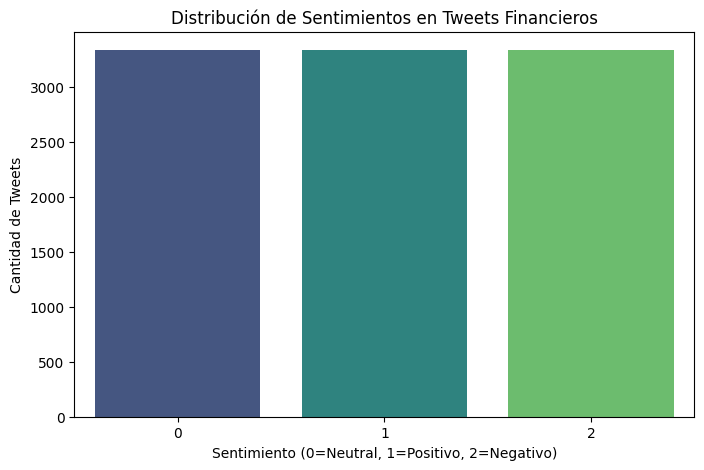


=== VISUALIZACIÓN DE EMBEDDINGS ===
Usando embeddings BERT para visualización...
Aplicando reducción dimensional a 50 embeddings...


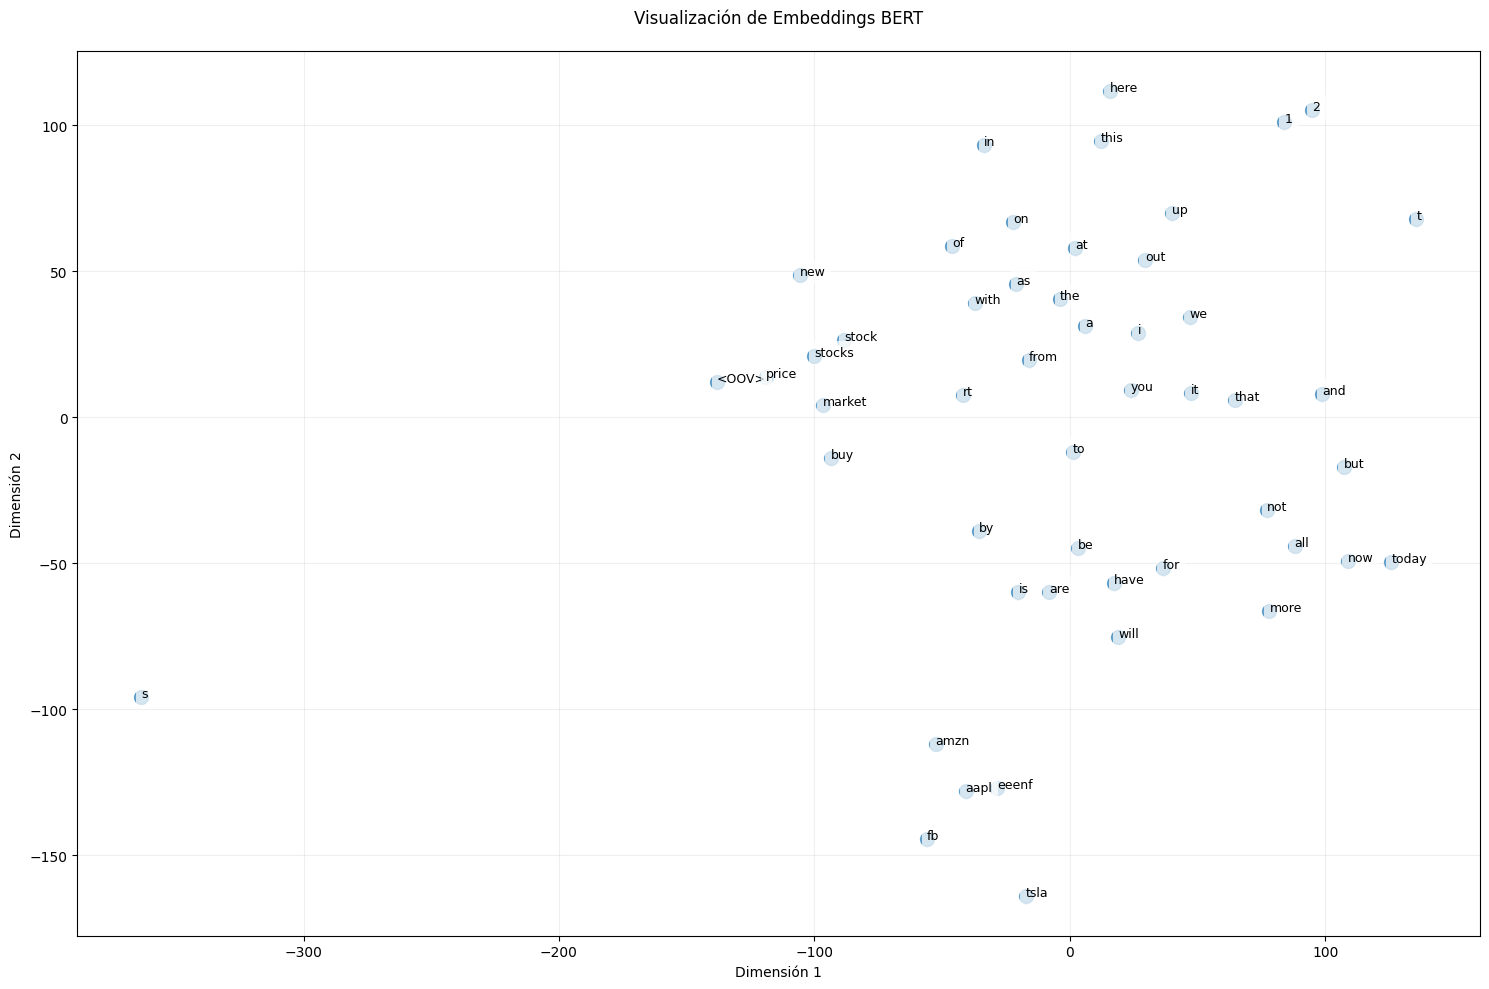


=== VISUALIZACIÓN DE TÉRMINOS FINANCIEROS ===
Visualizando 30 términos financieros...


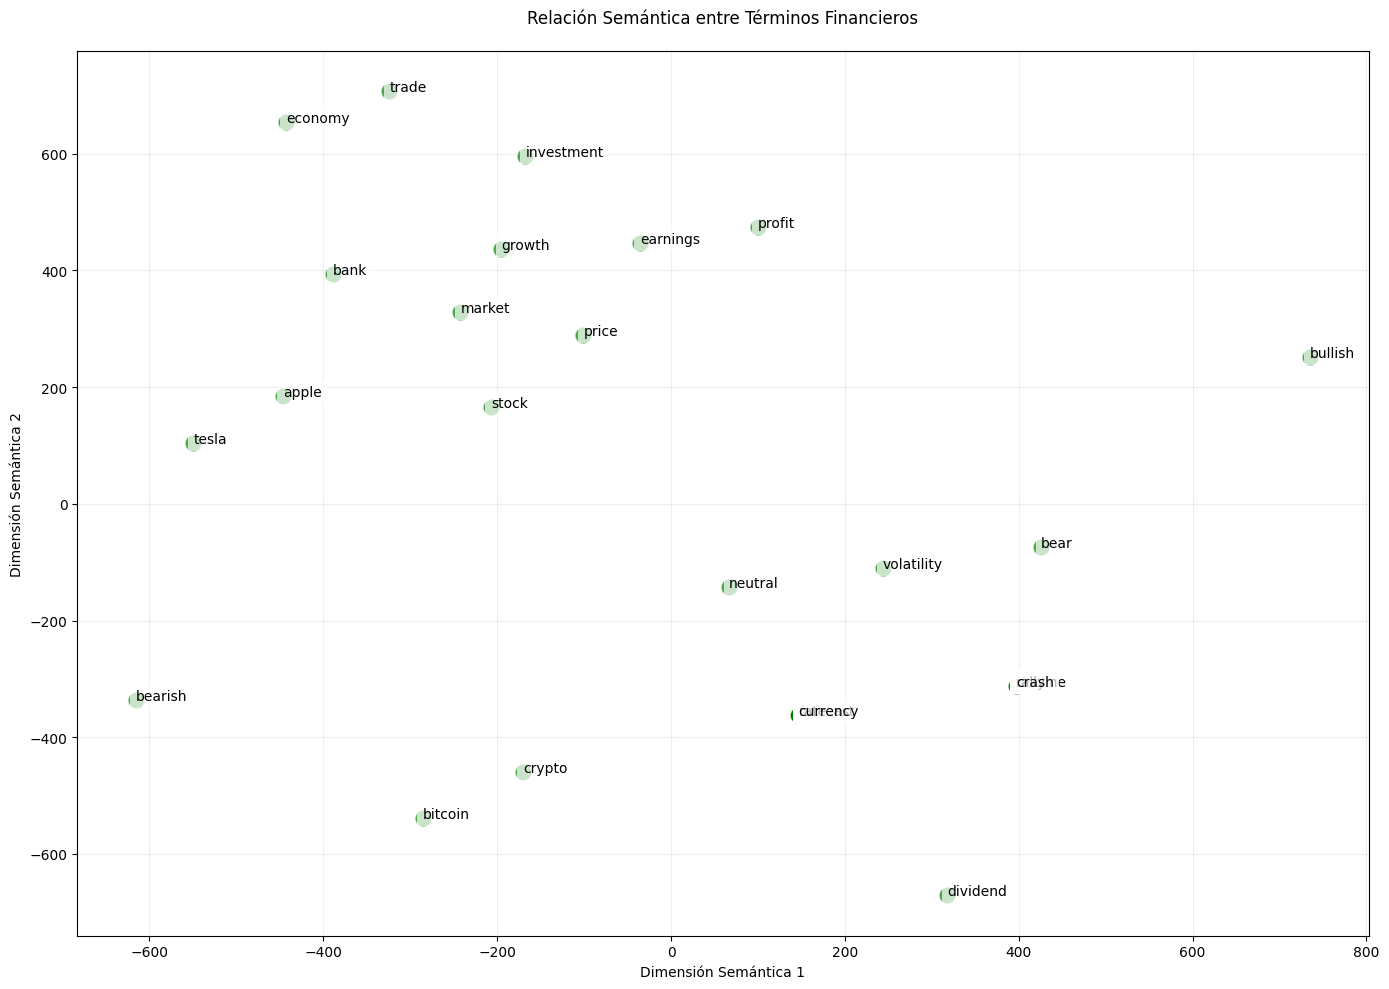

In [3]:
#####################################################################
# BLOQUE ADICIONAL: VISUALIZACIÓN CORREGIDA DE EMBEDDINGS
#####################################################################

# 1. Visualización de muestra de datos limpios
print("\n=== MUESTRA DE DATOS LIMPIOS ===")
print("Texto original vs. Texto procesado:")
sample_df = df.sample(5, random_state=42)[['text', 'processed_text', 'label']]
display(sample_df)

# 2. Visualización de distribución de clases
plt.figure(figsize=(8, 5))
sns.countplot(x='label', data=df, palette='viridis')
plt.title('Distribución de Sentimientos en Tweets Financieros')
plt.xlabel('Sentimiento (0=Neutral, 1=Positivo, 2=Negativo)')
plt.ylabel('Cantidad de Tweets')
plt.show()

# 3. Visualización mejorada de embeddings con manejo de errores
print("\n=== VISUALIZACIÓN DE EMBEDDINGS ===")

def safe_tsne(embeddings, n_components=2, perplexity=5, random_state=42):
    """Función segura para aplicar t-SNE con parámetros automáticos"""
    from sklearn.manifold import TSNE
    n_samples = embeddings.shape[0]

    # Ajustar perplexity automáticamente si es necesario
    safe_perplexity = min(perplexity, n_samples - 1) if n_samples > 1 else 1

    try:
        tsne = TSNE(n_components=n_components,
                   perplexity=safe_perplexity,
                   random_state=random_state)
        return tsne.fit_transform(embeddings)
    except Exception as e:
        print(f"Error en t-SNE: {e}. Usando PCA como alternativa...")
        from sklearn.decomposition import PCA
        pca = PCA(n_components=n_components)
        return pca.fit_transform(embeddings)

# Configuración
num_words_to_plot = min(50, len(tokenizer.word_index))  # Máximo 50 palabras

# Obtener palabras más frecuentes
top_words = [word for word, _ in sorted(tokenizer.word_index.items(), key=lambda x: x[1])][:num_words_to_plot]

# Verificar embeddings disponibles
use_bert = 'bert_embedding_matrix' in locals()
embedding_source = "BERT" if use_bert else "tradicionales"
print(f"Usando embeddings {embedding_source} para visualización...")

# Obtener embeddings
word_embeddings = {}
for word in top_words:
    try:
        if use_bert:
            if word in tokenizer.word_index and tokenizer.word_index[word] < len(bert_embedding_matrix):
                word_embeddings[word] = bert_embedding_matrix[tokenizer.word_index[word]]
        else:
            # Crear embedding dummy basado en frecuencia si no hay BERT
            word_embeddings[word] = np.array([tokenizer.word_index[word]])
    except Exception as e:
        print(f"Error obteniendo embedding para '{word}': {e}")

if not word_embeddings:
    print("No se encontraron embeddings válidos. Creando datos de ejemplo...")
    word_embeddings = {f"word_{i}": np.random.rand(10) for i in range(num_words_to_plot)}

# Convertir a matriz
words = list(word_embeddings.keys())
embeddings = np.array(list(word_embeddings.values()))

# Asegurar dimensionalidad mínima
if embeddings.ndim == 1:
    embeddings = embeddings.reshape(-1, 1)
if embeddings.shape[1] < 2:
    embeddings = np.hstack([embeddings, np.zeros((embeddings.shape[0], 2 - embeddings.shape[1]))])

# Reducción dimensional segura
print(f"Aplicando reducción dimensional a {len(embeddings)} embeddings...")
embeddings_2d = safe_tsne(embeddings) if len(embeddings) > 1 else embeddings[:, :2]

# Visualización
plt.figure(figsize=(15, 10))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], alpha=0.6, s=100)

# Añadir etiquetas
for i, word in enumerate(words):
    plt.annotate(word, (embeddings_2d[i, 0], embeddings_2d[i, 1]),
                fontsize=9,
                bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))

plt.title(f'Visualización de Embeddings {embedding_source}', pad=20)
plt.xlabel('Dimensión 1')
plt.ylabel('Dimensión 2')
plt.grid(alpha=0.2)
plt.tight_layout()
plt.show()

# 4. Visualización especial para términos financieros (solo si hay suficientes datos)
if use_bert and len(word_embeddings) > 3:
    print("\n=== VISUALIZACIÓN DE TÉRMINOS FINANCIEROS ===")

    finance_terms = ['bull', 'bear', 'market', 'price', 'stock', 'earnings',
                    'dollar', 'investment', 'profit', 'loss', 'apple', 'tesla',
                    'growth', 'decline', 'rally', 'crash', 'dividend', 'volatility',
                    'bullish', 'bearish', 'neutral', 'forecast', 'economy', 'trade',
                    'bank', 'fed', 'rate', 'currency', 'crypto', 'bitcoin']

    # Filtrar términos existentes
    valid_terms = [term for term in finance_terms
                  if term in word_embeddings or
                  (term in tokenizer.word_index and tokenizer.word_index[term] < len(bert_embedding_matrix))]

    if len(valid_terms) > 3:  # Necesitamos al menos 4 términos para t-SNE
        print(f"Visualizando {len(valid_terms)} términos financieros...")

        # Obtener embeddings
        term_embeddings = []
        valid_words = []
        for term in valid_terms:
            try:
                if term in word_embeddings:
                    term_embeddings.append(word_embeddings[term])
                    valid_words.append(term)
                elif term in tokenizer.word_index and tokenizer.word_index[term] < len(bert_embedding_matrix):
                    term_embeddings.append(bert_embedding_matrix[tokenizer.word_index[term]])
                    valid_words.append(term)
            except:
                continue

        term_embeddings = np.array(term_embeddings)

        # Reducción dimensional segura
        term_embeddings_2d = safe_tsne(term_embeddings) if len(term_embeddings) > 3 else term_embeddings[:, :2]

        # Visualización
        plt.figure(figsize=(14, 10))
        plt.scatter(term_embeddings_2d[:, 0], term_embeddings_2d[:, 1],
                   c='green', alpha=0.7, s=150, edgecolor='w')

        for i, term in enumerate(valid_words):
            plt.annotate(term, (term_embeddings_2d[i, 0], term_embeddings_2d[i, 1]),
                        fontsize=10,
                        bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))

        plt.title('Relación Semántica entre Términos Financieros', pad=20)
        plt.xlabel('Dimensión Semántica 1')
        plt.ylabel('Dimensión Semántica 2')
        plt.grid(alpha=0.2)
        plt.tight_layout()
        plt.show()
    else:
        print(f"Solo {len(valid_terms)} términos financieros encontrados (se necesitan al menos 4 para visualización)")
else:
    print("No hay suficientes datos para visualización especializada de términos financieros")

## Entrenamiento de diferentes RNN para análisis de sentimiento


**Esta sección del código** implementa y evalúa diferentes arquitecturas de **Redes Neuronales Recurrentes (RNN)** para la clasificación de sentimiento en tweets financieros.

El proceso comienza definiendo una **función flexible para crear modelos RNN** que permite experimentar con distintas configuraciones: **SimpleRNN básicas, LSTM con memoria de largo plazo, o GRU más eficientes computacionalmente**. La función también incorpora opciones para utilizar **capas bidireccionales** (que procesan el texto en ambas direcciones) y elegir entre **embeddings tradicionales o pre-entrenados de BERT**.

El núcleo de esta sección es la implementación de un exhaustivo **Grid Search**, una técnica de optimización que prueba sistemáticamente **24 combinaciones diferentes de hiperparámetros** (3 tipos de RNN × 2 opciones de bidireccionalidad × 2 tamaños de unidades × 2 tasas de aprendizaje), tanto con embeddings tradicionales como con BERT, resultando en **48 modelos evaluados en total**.

Para cada modelo, se registran métricas clave como **accuracy, F1-score y tiempo de ejecución**. El código implementa **early stopping** para evitar sobreajuste, deteniendo el entrenamiento cuando el rendimiento deja de mejorar en el conjunto de validación.

Finalmente, todos los resultados se combinan, ordenan por precisión, y se presentan los **5 mejores modelos** con sus configuraciones detalladas, proporcionando una visión clara de qué arquitecturas y parámetros ofrecen mejor rendimiento para la clasificación de sentimiento en tweets del ámbito financiero.





In [4]:

#####################################################################
# SECCIÓN 3: IMPLEMENTACIÓN Y EVALUACIÓN DE MODELOS RNN
#####################################################################

print("\nPreparando Grid Search para RNN...")

# Determinar número de clases para la capa de salida
num_classes = len(df['label'].unique())
print(f"Número de clases a predecir: {num_classes}")

# Función para crear diferentes modelos RNN
def create_rnn_model(model_type='lstm', bidirectional=False, units=64,
                   learning_rate=0.001, dropout_rate=0.3, use_bert=False):
    """
    Crea un modelo RNN con diferentes configuraciones

    Args:
        model_type: Tipo de celda recurrente ('simple_rnn', 'lstm', 'gru')
        bidirectional: Si usar capa bidireccional
        units: Número de unidades en la capa recurrente
        learning_rate: Tasa de aprendizaje
        dropout_rate: Tasa de dropout
        use_bert: Si usar embeddings BERT pre-entrenados
    """
    # Input layer - recibe secuencias de índices
    inp = Input(shape=(max_len,))

    # Embedding layer - convierte índices en vectores densos
    if use_bert:
        # Usar embeddings BERT (enfoque de transfer learning)
        x = Embedding(
            input_dim=vocab_size,
            output_dim=bert_embedding_matrix.shape[1],
            weights=[bert_embedding_matrix],
            input_length=max_len,
            trainable=False  # No se actualizan durante el entrenamiento
        )(inp)
    else:
        # Embedding tradicional (se aprende durante el entrenamiento)
        x = Embedding(
            input_dim=vocab_size,
            output_dim=128,  # Dimensionalidad del embedding (hiperparámetro)
            input_length=max_len
        )(inp)

    # Seleccionar tipo de capa recurrente
    # NOTA PARA ESTUDIANTES: Cada tipo tiene características diferentes:
    # - SimpleRNN: La más básica, problemas con dependencias largas
    # - LSTM: Mejor memoria de largo plazo, más parámetros
    # - GRU: Similar a LSTM pero más eficiente computacionalmente
    if model_type == 'simple_rnn':
        rnn_layer = SimpleRNN(units, return_sequences=True)
    elif model_type == 'lstm':
        rnn_layer = LSTM(units, return_sequences=True)
    else:  # gru
        rnn_layer = GRU(units, return_sequences=True)

    # Aplicar capa recurrente
    if bidirectional:
        x = Bidirectional(rnn_layer)(x)
    else:
        x = rnn_layer(x)

    # Global Pooling - colapsa la secuencia a un vector fijo
    x = GlobalMaxPooling1D()(x)

    # Dropout - técnica de regularización para evitar sobreajuste
    x = Dropout(dropout_rate)(x)

    # Capa de salida - softmax para clasificación multiclase
    out = Dense(num_classes, activation='softmax')(x)

    # Compilar modelo
    model = Model(inputs=inp, outputs=out)
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='sparse_categorical_crossentropy',  # Para etiquetas enteras (no one-hot)
        metrics=['accuracy']
    )

    return model

# Definir parámetros para el grid search
param_grid = {
    'model_type': ['lstm', 'gru'],           # Tipo de RNN
    'bidirectional': [False, True],                         # Usar o no capa bidireccional
    'units': [32, 64],                                      # Número de unidades (neuronas)
    'learning_rate': [0.001, 0.0001],                       # Tasa de aprendizaje
    'batch_size': [32],                                     # Tamaño del lote
    'epochs': [10]                                           # Épocas de entrenamiento
}

# Función para realizar grid search
def run_grid_search(param_grid, X_train, y_train, X_val, y_val, use_bert=False):
    """
    Realiza grid search sobre los hiperparámetros
    """
    # Generar todas las combinaciones posibles de hiperparámetros
    keys = param_grid.keys()
    combinations = list(itertools.product(*param_grid.values()))
    param_combinations = [dict(zip(keys, combo)) for combo in combinations]

    # Lista para almacenar resultados
    results = []

    print(f"Probando {len(param_combinations)} combinaciones de modelos...")

    # Probar cada combinación
    for i, params in enumerate(param_combinations):
        start_time = time.time()

        # Extraer parámetros
        model_type = params['model_type']
        bidirectional = params['bidirectional']
        units = params['units']
        learning_rate = params['learning_rate']
        batch_size = params['batch_size']
        epochs = params['epochs']

        # Crear nombre descriptivo para el modelo
        model_name = f"{model_type.upper()}"
        if bidirectional:
            model_name = f"Bi{model_name}"
        model_name += f"_u{units}_lr{learning_rate}"
        if use_bert:
            model_name += "_BERT"

        print(f"\n[{i+1}/{len(param_combinations)}] Entrenando {model_name}...")

        # Crear modelo con los parámetros actuales
        model = create_rnn_model(
            model_type=model_type,
            bidirectional=bidirectional,
            units=units,
            learning_rate=learning_rate,
            dropout_rate=0.3,  # Fijo para simplificar
            use_bert=use_bert
        )

        # Early stopping - detiene el entrenamiento cuando deja de mejorar
        early_stopping = EarlyStopping(
            monitor='val_accuracy',
            patience=2,  # Número de épocas sin mejora antes de detenerse
            restore_best_weights=True  # Restaura los mejores pesos encontrados
        )

        # Entrenar modelo
        history = model.fit(
            X_train,
            y_train,
            validation_data=(X_val, y_val),
            epochs=epochs,
            batch_size=batch_size,
            callbacks=[early_stopping],
            verbose=1
        )

        # Evaluar modelo en conjunto de validación
        y_pred_probs = model.predict(X_val)
        y_pred = np.argmax(y_pred_probs, axis=1)

        # Calcular métricas de rendimiento
        accuracy = accuracy_score(y_val, y_pred)
        f1 = f1_score(y_val, y_pred, average='weighted')

        # Tiempo de ejecución
        execution_time = time.time() - start_time

        # Guardar resultados
        result = {
            'model_name': model_name,
            'model_type': model_type,
            'bidirectional': bidirectional,
            'units': units,
            'learning_rate': learning_rate,
            'batch_size': batch_size,
            'accuracy': accuracy,
            'f1_score': f1,
            'execution_time': execution_time,
            'use_bert': use_bert
        }

        results.append(result)

        print(f"Resultado: Acc={accuracy:.4f}, F1={f1:.4f}, Tiempo={execution_time:.1f}s")

    # Ordenar resultados por precisión (de mayor a menor)
    results_sorted = sorted(results, key=lambda x: x['accuracy'], reverse=True)

    return results_sorted

# Ejecutar grid search con embeddings tradicionales
print("\nEjecutando grid search con embeddings tradicionales...")
results_traditional = run_grid_search(
    param_grid,
    X_train_pad,
    y_train,
    X_test_pad,
    y_test,
    use_bert=False
)

# Ejecutar grid search con BERT embeddings
print("\nEjecutando grid search con embeddings BERT...")
results_bert = run_grid_search(
    param_grid,
    X_train_pad,
    y_train,
    X_test_pad,
    y_test,
    use_bert=True
)

# Combinar y ordenar todos los resultados
all_results = results_traditional + results_bert
all_results_sorted = sorted(all_results, key=lambda x: x['accuracy'], reverse=True)

# Mostrar los mejores resultados
print("\n=== RESULTADOS DEL GRID SEARCH ===")
print("\nTop modelos por precisión:")
for i, result in enumerate(all_results_sorted[:5]):
    print(f"\n{i+1}. {result['model_name']}:")
    print(f"   Accuracy: {result['accuracy']:.4f}")
    print(f"   F1-Score: {result['f1_score']:.4f}")
    print(f"   Tiempo: {result['execution_time']:.1f}s")
    print(f"   Usa BERT: {result['use_bert']}")
    print(f"   Tipo: {result['model_type'].upper()}, Bidireccional: {result['bidirectional']}")

# Crear DataFrame para visualización
results_df = pd.DataFrame(all_results_sorted)


Preparando Grid Search para RNN...
Número de clases a predecir: 3

Ejecutando grid search con embeddings tradicionales...
Probando 16 combinaciones de modelos...

[1/16] Entrenando LSTM_u32_lr0.001...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 16s 22ms/step - accuracy: 0.4227 - loss: 1.0598 - val_accuracy: 0.6580 - val_loss: 0.8279
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.7181 - loss: 0.6991 - val_accuracy: 0.6555 - val_loss: 0.8298
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - accuracy: 0.8597 - loss: 0.3947 - val_accuracy: 0.6525 - val_loss: 0.9960
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Resultado: Acc=0.6580, F1=0.6571, Tiempo=30.6s

[2/16] Entrenando LSTM_u32_lr0.0001...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - accuracy: 0.3484 - loss: 1.0975 - val_accuracy: 0.4810 - val_loss: 1.0899
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.4905 - loss: 1.0823 - val_accuracy: 0.4915 - val_loss: 1.0119
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.5381 - loss: 0.9631 - val_accuracy: 0.5190 - val_loss: 0.9710
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.6251 - loss: 0.8191 - val_accuracy: 0.5380 - val_loss: 0.9659
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.6760 - loss: 0.7243 - val_accuracy: 0.5640 - val_loss: 0.9803
Epoch 6/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.7164 - loss: 0.6426 - val_accuracy: 0.5650 - val_loss: 1.0043
Epoch 7/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.7352 - loss: 0.6155 - val_accuracy: 0.5400 - val_loss: 1.0314
Epoch 8/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.7627 - loss: 0.5669 - val_accuracy:

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.4299 - loss: 1.0539 - val_accuracy: 0.6585 - val_loss: 0.8045
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.7316 - loss: 0.6650 - val_accuracy: 0.6775 - val_loss: 0.8319
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8649 - loss: 0.3630 - val_accuracy: 0.6455 - val_loss: 0.9817
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9290 - loss: 0.2075 - val_accuracy: 0.6500 - val_loss: 1.0523
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Resultado: Acc=0.6775, F1=0.6772, Tiempo=11.1s

[4/16] Entrenando LSTM_u64_lr0.0001...
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.3273 - loss: 1.0987 - val_accuracy: 0.3760 - val_loss: 1.0946
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.4524 - loss: 1.0908 - val_accuracy: 0.5365 - val_loss: 1.0754
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.5461 - loss: 0.9904 - val_accuracy: 0.5765 - val_loss: 0.9187
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.6389 - loss: 0.7587 - val_accuracy: 0.5940 - val_loss: 0.9313
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.7076 - loss: 0.6380 - val_accuracy: 0.6025 - val_loss: 0.9983
Epoch 6/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8159 - loss: 0.5061 - val_accuracy: 0.6550 - val_loss: 1.0135
Epoch 7/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8743 - loss: 0.3889 - val_accuracy: 0.6635 - val_loss: 0.9877
Epoch 8/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.9062 - loss: 0.3235 - val_accuracy: 0.6630 - va

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.4394 - loss: 1.0433 - val_accuracy: 0.6625 - val_loss: 0.7780
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.7275 - loss: 0.6537 - val_accuracy: 0.6745 - val_loss: 0.8209
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.8737 - loss: 0.3531 - val_accuracy: 0.6600 - val_loss: 1.0394
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9283 - loss: 0.1998 - val_accuracy: 0.6680 - val_loss: 1.1520
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
Resultado: Acc=0.6745, F1=0.6737, Tiempo=18.9s

[6/16] Entrenando BiLSTM_u32_lr0.0001...
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


250/250 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.3590 - loss: 1.0971 - val_accuracy: 0.4775 - val_loss: 1.0908
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.5102 - loss: 1.0848 - val_accuracy: 0.5970 - val_loss: 1.0694
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.6263 - loss: 1.0398 - val_accuracy: 0.5035 - val_loss: 0.9632
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.6221 - loss: 0.8435 - val_accuracy: 0.6175 - val_loss: 0.8576
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.7789 - loss: 0.6104 - val_accuracy: 0.6630 - val_loss: 0.8442
Epoch 6/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.8468 - loss: 0.4728 - val_accuracy: 0.6610 - val_loss: 0.8975
Epoch 7/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.8749 - loss: 0.4035 - val_accuracy: 0.6645 - val_loss: 0.9171
Epoch 8/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.8976 - loss: 0.3420 - val_accuracy: 0.664

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


250/250 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.4433 - loss: 1.0431 - val_accuracy: 0.6700 - val_loss: 0.7582
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.7439 - loss: 0.6202 - val_accuracy: 0.6755 - val_loss: 0.8257
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.8764 - loss: 0.3354 - val_accuracy: 0.6720 - val_loss: 1.0190
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.9436 - loss: 0.1771 - val_accuracy: 0.6565 - val_loss: 1.3452
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Resultado: Acc=0.6755, F1=0.6746, Tiempo=22.0s

[8/16] Entrenando BiLSTM_u64_lr0.0001...
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.3523 - loss: 1.0975 - val_accuracy: 0.4580 - val_loss: 1.0908
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.5201 - loss: 1.0820 - val_accuracy: 0.5190 - val_loss: 1.0434
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.5661 - loss: 0.9501 - val_accuracy: 0.5520 - val_loss: 0.9183
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.6812 - loss: 0.7431 - val_accuracy: 0.6145 - val_loss: 0.9124
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.7541 - loss: 0.6123 - val_accuracy: 0.6200 - val_loss: 0.9442
Epoch 6/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.8138 - loss: 0.4785 - val_accuracy: 0.6390 - val_loss: 1.0140
Epoch 7/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.8695 - loss: 0.3793 - val_accuracy: 0.6355 - val_loss: 1.0140
Epoch 8/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.8953 - loss: 0.3093 - val_accuracy: 0.643

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.4434 - loss: 1.0523 - val_accuracy: 0.6610 - val_loss: 0.7843
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.7177 - loss: 0.6837 - val_accuracy: 0.6620 - val_loss: 0.8799
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.8648 - loss: 0.3801 - val_accuracy: 0.6535 - val_loss: 0.9902
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.9281 - loss: 0.2210 - val_accuracy: 0.6585 - val_loss: 1.1754
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Resultado: Acc=0.6620, F1=0.6607, Tiempo=15.4s

[10/16] Entrenando GRU_u32_lr0.0001...
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.3626 - loss: 1.0959 - val_accuracy: 0.4680 - val_loss: 1.0857
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.5005 - loss: 1.0757 - val_accuracy: 0.5400 - val_loss: 1.0622
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.6078 - loss: 1.0433 - val_accuracy: 0.5985 - val_loss: 1.0205
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.6656 - loss: 0.9815 - val_accuracy: 0.6455 - val_loss: 0.9378
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.6730 - loss: 0.8505 - val_accuracy: 0.6090 - val_loss: 0.9159
Epoch 6/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.7140 - loss: 0.7126 - val_accuracy: 0.6200 - val_loss: 0.9282
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Resultado: Acc=0.6455, F1=0.6447, Tiempo=14.8s

[11/16] Entrenando GRU_u64_lr0.001...
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.4518 - loss: 1.0462 - val_accuracy: 0.6555 - val_loss: 0.7875
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.7216 - loss: 0.6584 - val_accuracy: 0.6580 - val_loss: 0.8819
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8702 - loss: 0.3617 - val_accuracy: 0.6560 - val_loss: 1.1168
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9345 - loss: 0.2000 - val_accuracy: 0.6590 - val_loss: 1.0689
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9529 - loss: 0.1461 - val_accuracy: 0.6520 - val_loss: 1.4716
Epoch 6/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9682 - loss: 0.0925 - val_accuracy: 0.6535 - val_loss: 1.5515
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Resultado: Acc=0.6590, F1=0.6594, Tiempo=19.9s

[12/16] Entrenando GRU_u64_lr0.0001...
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.3682 - loss: 1.0970 - val_accuracy: 0.4935 - val_loss: 1.0878
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.5362 - loss: 1.0786 - val_accuracy: 0.5695 - val_loss: 1.0630
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.6359 - loss: 1.0366 - val_accuracy: 0.5945 - val_loss: 0.9867
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.6183 - loss: 0.8953 - val_accuracy: 0.5535 - val_loss: 0.9527
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.6972 - loss: 0.7186 - val_accuracy: 0.5800 - val_loss: 0.9342
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Resultado: Acc=0.5945, F1=0.5932, Tiempo=16.5s

[13/16] Entrenando BiGRU_u32_lr0.001...
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


250/250 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.4591 - loss: 1.0395 - val_accuracy: 0.6655 - val_loss: 0.7675
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.7288 - loss: 0.6443 - val_accuracy: 0.6845 - val_loss: 0.8229
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.8721 - loss: 0.3360 - val_accuracy: 0.6645 - val_loss: 0.9891
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9423 - loss: 0.1725 - val_accuracy: 0.6655 - val_loss: 1.1818
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Resultado: Acc=0.6845, F1=0.6840, Tiempo=19.0s

[14/16] Entrenando BiGRU_u32_lr0.0001...
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.3644 - loss: 1.0957 - val_accuracy: 0.5095 - val_loss: 1.0832
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.5195 - loss: 1.0749 - val_accuracy: 0.5770 - val_loss: 1.0572
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.6204 - loss: 1.0391 - val_accuracy: 0.5980 - val_loss: 1.0101
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.6594 - loss: 0.9739 - val_accuracy: 0.6290 - val_loss: 0.9214
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.6986 - loss: 0.8288 - val_accuracy: 0.6640 - val_loss: 0.8557
Epoch 6/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.7599 - loss: 0.6695 - val_accuracy: 0.6705 - val_loss: 0.8267
Epoch 7/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.8256 - loss: 0.5282 - val_accuracy: 0.6560 - val_loss: 0.9246
Epoch 8/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.8656 - loss: 0.4288 - val_accuracy: 0.675

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.4562 - loss: 1.0370 - val_accuracy: 0.6825 - val_loss: 0.7473
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.7406 - loss: 0.6345 - val_accuracy: 0.6720 - val_loss: 0.8693
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.8766 - loss: 0.3304 - val_accuracy: 0.6670 - val_loss: 1.1087
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Resultado: Acc=0.6825, F1=0.6819, Tiempo=11.3s

[16/16] Entrenando BiGRU_u64_lr0.0001...
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.3597 - loss: 1.0961 - val_accuracy: 0.5120 - val_loss: 1.0863
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.5175 - loss: 1.0774 - val_accuracy: 0.5655 - val_loss: 1.0604
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.6269 - loss: 1.0388 - val_accuracy: 0.6050 - val_loss: 0.9874
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.6336 - loss: 0.9138 - val_accuracy: 0.5925 - val_loss: 0.9002
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.7126 - loss: 0.6936 - val_accuracy: 0.6410 - val_loss: 0.8745
Epoch 6/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8075 - loss: 0.5256 - val_accuracy: 0.6620 - val_loss: 0.8828
Epoch 7/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.8520 - loss: 0.4217 - val_accuracy: 0.6535 - val_loss: 0.9606
Epoch 8/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.8825 - loss: 0.3490 - val_accuracy: 0.653

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.4348 - loss: 1.0598 - val_accuracy: 0.5205 - val_loss: 0.9835
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.5265 - loss: 0.9654 - val_accuracy: 0.5480 - val_loss: 0.9423
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.5574 - loss: 0.9205 - val_accuracy: 0.5655 - val_loss: 0.9257
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.5786 - loss: 0.8989 - val_accuracy: 0.5730 - val_loss: 0.9053
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.5886 - loss: 0.8805 - val_accuracy: 0.5835 - val_loss: 0.8894
Epoch 6/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.6055 - loss: 0.8546 - val_accuracy: 0.5855 - val_loss: 0.8823
Epoch 7/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.6209 - loss: 0.8357 - val_accuracy: 0.5745 - val_loss: 0.8923
Epoch 8/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.6209 - loss: 0.8315 - val_accuracy: 0.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.3878 - loss: 1.0832 - val_accuracy: 0.4890 - val_loss: 1.0348
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.4704 - loss: 1.0314 - val_accuracy: 0.5130 - val_loss: 1.0043
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.5129 - loss: 0.9986 - val_accuracy: 0.5165 - val_loss: 0.9836
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.5201 - loss: 0.9736 - val_accuracy: 0.5355 - val_loss: 0.9647
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.5347 - loss: 0.9609 - val_accuracy: 0.5480 - val_loss: 0.9658
Epoch 6/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.5489 - loss: 0.9411 - val_accuracy: 0.5495 - val_loss: 0.9467
Epoch 7/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.5597 - loss: 0.9325 - val_accuracy: 0.5580 - val_loss: 0.9405
Epoch 8/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.5757 - loss: 0.9178 - val_accuracy: 0.5490 - val

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.4503 - loss: 1.0433 - val_accuracy: 0.5500 - val_loss: 0.9427
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.5546 - loss: 0.9344 - val_accuracy: 0.5555 - val_loss: 0.9252
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.5839 - loss: 0.8970 - val_accuracy: 0.5825 - val_loss: 0.8923
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.6029 - loss: 0.8670 - val_accuracy: 0.5770 - val_loss: 0.8806
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.6113 - loss: 0.8466 - val_accuracy: 0.5920 - val_loss: 0.8746
Epoch 6/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.6189 - loss: 0.8272 - val_accuracy: 0.5620 - val_loss: 0.8964
Epoch 7/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.6258 - loss: 0.8165 - val_accuracy: 0.5560 - val_loss: 0.8992
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Resultado: Acc=0.5920, F1=0.5917, Tiempo=18.5s

[4/16] Entrenando

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.3937 - loss: 1.0785 - val_accuracy: 0.5000 - val_loss: 1.0169
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.4877 - loss: 1.0143 - val_accuracy: 0.5300 - val_loss: 0.9788
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.5379 - loss: 0.9669 - val_accuracy: 0.5465 - val_loss: 0.9504
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.5480 - loss: 0.9361 - val_accuracy: 0.5520 - val_loss: 0.9386
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.5665 - loss: 0.9225 - val_accuracy: 0.5575 - val_loss: 0.9303
Epoch 6/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.5852 - loss: 0.9003 - val_accuracy: 0.5655 - val_loss: 0.9164
Epoch 7/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.5983 - loss: 0.8801 - val_accuracy: 0.5700 - val_loss: 0.9157
Epoch 8/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.5967 - loss: 0.8716 - val_accuracy: 0.5695 - val

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.4430 - loss: 1.0426 - val_accuracy: 0.5545 - val_loss: 0.9514
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.5456 - loss: 0.9431 - val_accuracy: 0.5755 - val_loss: 0.9173
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.5582 - loss: 0.9136 - val_accuracy: 0.5685 - val_loss: 0.9112
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.5812 - loss: 0.8797 - val_accuracy: 0.5835 - val_loss: 0.8924
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.6034 - loss: 0.8633 - val_accuracy: 0.5810 - val_loss: 0.8919
Epoch 6/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.6105 - loss: 0.8439 - val_accuracy: 0.5790 - val_loss: 0.8910
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
Resultado: Acc=0.5835, F1=0.5808, Tiempo=23.5s

[6/16] Entrenando BiLSTM_u32_lr0.0001_BERT...
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.3901 - loss: 1.0832 - val_accuracy: 0.5035 - val_loss: 1.0169
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.5075 - loss: 1.0006 - val_accuracy: 0.5200 - val_loss: 0.9882
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.5201 - loss: 0.9732 - val_accuracy: 0.5375 - val_loss: 0.9683
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.5439 - loss: 0.9470 - val_accuracy: 0.5455 - val_loss: 0.9557
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.5540 - loss: 0.9313 - val_accuracy: 0.5470 - val_loss: 0.9395
Epoch 6/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.5777 - loss: 0.9016 - val_accuracy: 0.5490 - val_loss: 0.9379
Epoch 7/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.5792 - loss: 0.8951 - val_accuracy: 0.5600 - val_loss: 0.9236
Epoch 8/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.5892 - loss: 0.8810 - val_accuracy: 0.5445 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.4556 - loss: 1.0331 - val_accuracy: 0.5535 - val_loss: 0.9418
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.5606 - loss: 0.9222 - val_accuracy: 0.5580 - val_loss: 0.9107
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.5848 - loss: 0.8832 - val_accuracy: 0.5805 - val_loss: 0.8902
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.6005 - loss: 0.8604 - val_accuracy: 0.5770 - val_loss: 0.8845
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.6126 - loss: 0.8399 - val_accuracy: 0.5915 - val_loss: 0.8706
Epoch 6/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.6293 - loss: 0.8172 - val_accuracy: 0.5560 - val_loss: 0.9393
Epoch 7/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.6318 - loss: 0.8113 - val_accuracy: 0.5840 - val_loss: 0.8799
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Resultado: Acc=0.5915, F1=0.5922, Tiempo=25.5s

[8/16] Entrenando BiLST

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.4075 - loss: 1.0710 - val_accuracy: 0.4620 - val_loss: 1.0192
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.5026 - loss: 0.9922 - val_accuracy: 0.5095 - val_loss: 0.9900
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.5366 - loss: 0.9541 - val_accuracy: 0.5265 - val_loss: 0.9714
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.5571 - loss: 0.9243 - val_accuracy: 0.5290 - val_loss: 0.9572
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.5779 - loss: 0.9028 - val_accuracy: 0.5375 - val_loss: 0.9423
Epoch 6/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.5883 - loss: 0.8810 - val_accuracy: 0.5415 - val_loss: 0.9365
Epoch 7/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.5968 - loss: 0.8706 - val_accuracy: 0.5645 - val_loss: 0.9125
Epoch 8/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.6152 - loss: 0.8500 - val_accuracy: 0.564

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.4292 - loss: 1.0897 - val_accuracy: 0.5185 - val_loss: 0.9712
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.5309 - loss: 0.9645 - val_accuracy: 0.5225 - val_loss: 0.9615
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.5546 - loss: 0.9304 - val_accuracy: 0.5370 - val_loss: 0.9327
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.5761 - loss: 0.9065 - val_accuracy: 0.5725 - val_loss: 0.8986
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.5743 - loss: 0.8923 - val_accuracy: 0.5710 - val_loss: 0.8996
Epoch 6/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.5931 - loss: 0.8730 - val_accuracy: 0.5595 - val_loss: 0.9043
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Resultado: Acc=0.5725, F1=0.5733, Tiempo=15.4s

[10/16] Entrenando GRU_u32_lr0.0001_BERT...
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.3583 - loss: 1.1272 - val_accuracy: 0.4300 - val_loss: 1.0504
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.4621 - loss: 1.0396 - val_accuracy: 0.4660 - val_loss: 1.0217
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.4883 - loss: 1.0129 - val_accuracy: 0.4965 - val_loss: 0.9986
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.5190 - loss: 0.9882 - val_accuracy: 0.5145 - val_loss: 0.9784
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.5358 - loss: 0.9708 - val_accuracy: 0.5290 - val_loss: 0.9646
Epoch 6/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.5438 - loss: 0.9539 - val_accuracy: 0.5375 - val_loss: 0.9556
Epoch 7/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.5518 - loss: 0.9428 - val_accuracy: 0.5450 - val_loss: 0.9446
Epoch 8/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.5529 - loss: 0.9366 - val_accuracy: 0.5535 - val

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.4598 - loss: 1.0464 - val_accuracy: 0.5285 - val_loss: 0.9664
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.5467 - loss: 0.9349 - val_accuracy: 0.5595 - val_loss: 0.9218
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.5743 - loss: 0.8983 - val_accuracy: 0.5465 - val_loss: 0.9212
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.5905 - loss: 0.8749 - val_accuracy: 0.5480 - val_loss: 0.9151
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Resultado: Acc=0.5595, F1=0.5580, Tiempo=10.5s

[12/16] Entrenando GRU_u64_lr0.0001_BERT...
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.3775 - loss: 1.1141 - val_accuracy: 0.4775 - val_loss: 1.0260
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.4932 - loss: 1.0124 - val_accuracy: 0.5035 - val_loss: 0.9944
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.5301 - loss: 0.9786 - val_accuracy: 0.5330 - val_loss: 0.9701
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.5417 - loss: 0.9515 - val_accuracy: 0.5465 - val_loss: 0.9550
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.5615 - loss: 0.9274 - val_accuracy: 0.5545 - val_loss: 0.9389
Epoch 6/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.5644 - loss: 0.9208 - val_accuracy: 0.5650 - val_loss: 0.9312
Epoch 7/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.5818 - loss: 0.9035 - val_accuracy: 0.5650 - val_loss: 0.9220
Epoch 8/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.5830 - loss: 0.8890 - val_accuracy: 0.5700 - va

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


250/250 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.4407 - loss: 1.0540 - val_accuracy: 0.5260 - val_loss: 0.9535
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.5442 - loss: 0.9467 - val_accuracy: 0.5450 - val_loss: 0.9393
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.5676 - loss: 0.9107 - val_accuracy: 0.5425 - val_loss: 0.9272
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.5786 - loss: 0.8900 - val_accuracy: 0.5205 - val_loss: 0.9439
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Resultado: Acc=0.5450, F1=0.5372, Tiempo=18.7s

[14/16] Entrenando BiGRU_u32_lr0.0001_BERT...
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


250/250 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.3674 - loss: 1.1241 - val_accuracy: 0.4435 - val_loss: 1.0381
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.4846 - loss: 1.0104 - val_accuracy: 0.4985 - val_loss: 0.9958
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.5160 - loss: 0.9770 - val_accuracy: 0.5310 - val_loss: 0.9721
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.5420 - loss: 0.9522 - val_accuracy: 0.5420 - val_loss: 0.9566
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.5523 - loss: 0.9322 - val_accuracy: 0.5455 - val_loss: 0.9434
Epoch 6/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.5750 - loss: 0.9165 - val_accuracy: 0.5480 - val_loss: 0.9360
Epoch 7/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.5753 - loss: 0.9055 - val_accuracy: 0.5625 - val_loss: 0.9254
Epoch 8/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.5820 - loss: 0.8917 - val_accuracy: 0.562

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.4622 - loss: 1.0402 - val_accuracy: 0.5425 - val_loss: 0.9440
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.5530 - loss: 0.9216 - val_accuracy: 0.5510 - val_loss: 0.9129
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.5799 - loss: 0.8896 - val_accuracy: 0.5450 - val_loss: 0.9299
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.5910 - loss: 0.8730 - val_accuracy: 0.5725 - val_loss: 0.8937
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.6062 - loss: 0.8500 - val_accuracy: 0.5795 - val_loss: 0.8787
Epoch 6/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.6119 - loss: 0.8337 - val_accuracy: 0.5720 - val_loss: 0.8890
Epoch 7/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.6239 - loss: 0.8264 - val_accuracy: 0.5895 - val_loss: 0.8663
Epoch 8/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.6309 - loss: 0.8110 - val_accuracy: 0.584

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.3839 - loss: 1.0922 - val_accuracy: 0.5300 - val_loss: 0.9982
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.5078 - loss: 0.9863 - val_accuracy: 0.5460 - val_loss: 0.9590
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.5499 - loss: 0.9447 - val_accuracy: 0.5625 - val_loss: 0.9377
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.5610 - loss: 0.9192 - val_accuracy: 0.5735 - val_loss: 0.9217
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.5885 - loss: 0.8965 - val_accuracy: 0.5735 - val_loss: 0.9089
Epoch 6/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.5932 - loss: 0.8838 - val_accuracy: 0.5755 - val_loss: 0.9010
Epoch 7/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.5911 - loss: 0.8748 - val_accuracy: 0.5785 - val_loss: 0.8942
Epoch 8/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.6004 - loss: 0.8605 - val_accu

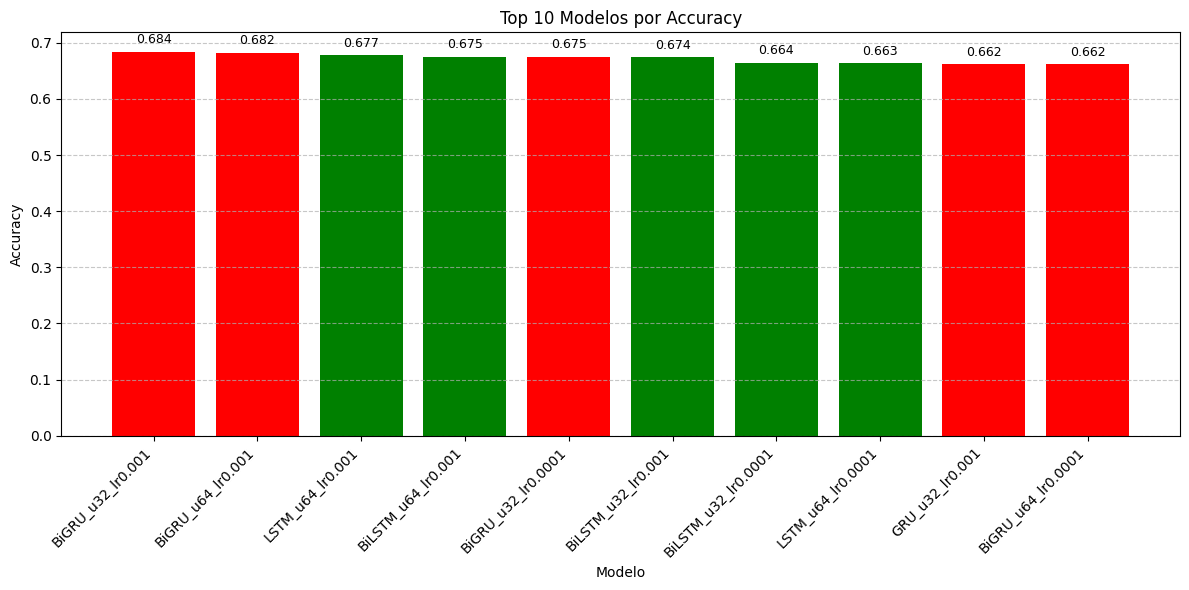

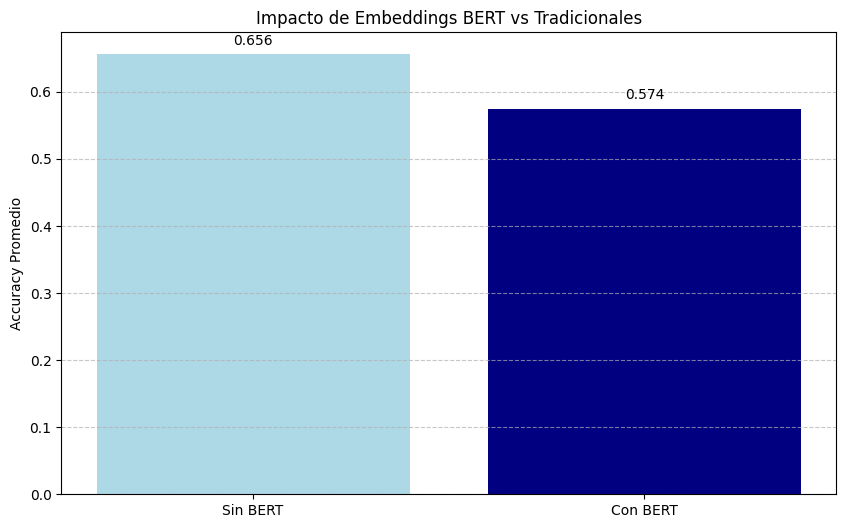

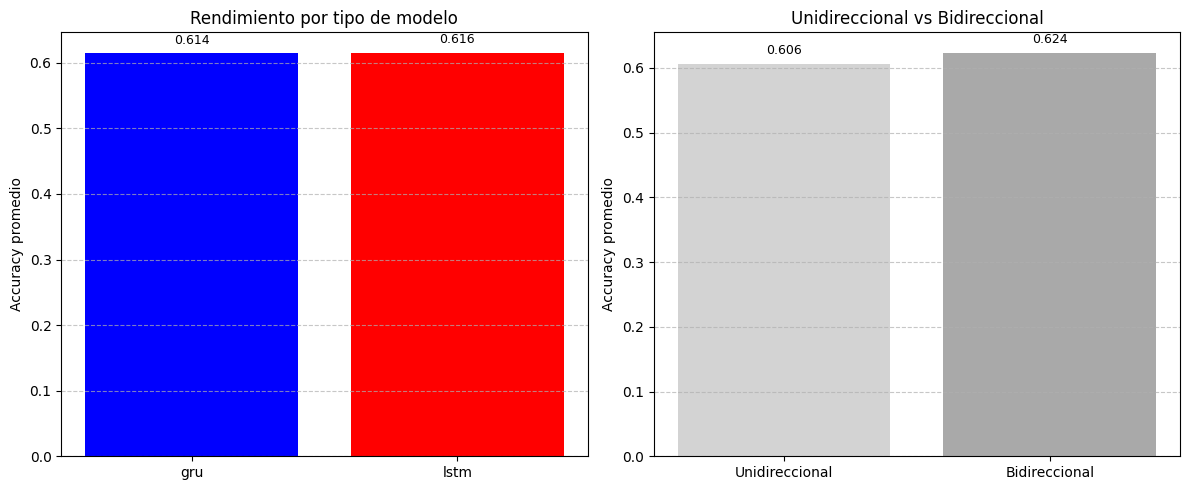


Mejor modelo: BiGRU_u32_lr0.001
Accuracy: 0.6845
F1-Score: 0.6840

Entrenando el mejor modelo con la configuración óptima...
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.4720 - loss: 1.0367 - val_accuracy: 0.6770 - val_loss: 0.7485
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.7370 - loss: 0.6386 - val_accuracy: 0.6635 - val_loss: 0.8688
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.8825 - loss: 0.3350 - val_accuracy: 0.6550 - val_loss: 1.0876
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9415 - loss: 0.1733 - val_accuracy: 0.6585 - val_loss: 1.1880
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


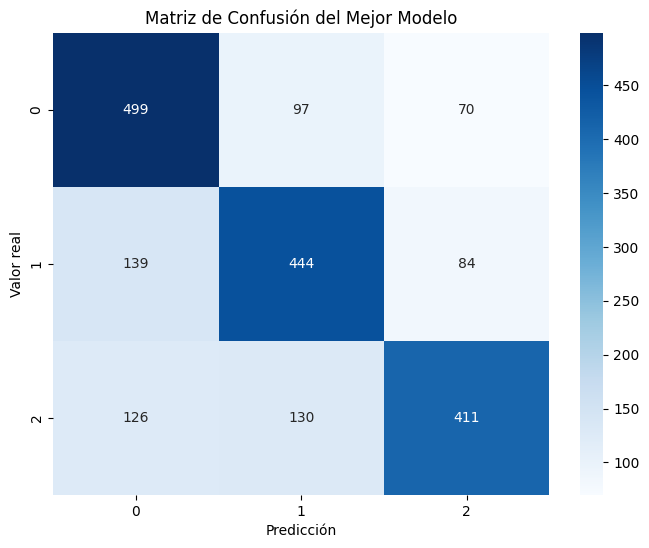


Reporte de clasificación del mejor modelo:
              precision    recall  f1-score   support

           0       0.65      0.75      0.70       666
           1       0.66      0.67      0.66       667
           2       0.73      0.62      0.67       667

    accuracy                           0.68      2000
   macro avg       0.68      0.68      0.68      2000
weighted avg       0.68      0.68      0.68      2000


Mejor modelo guardado como 'best_financial_sentiment_model_gru.keras'


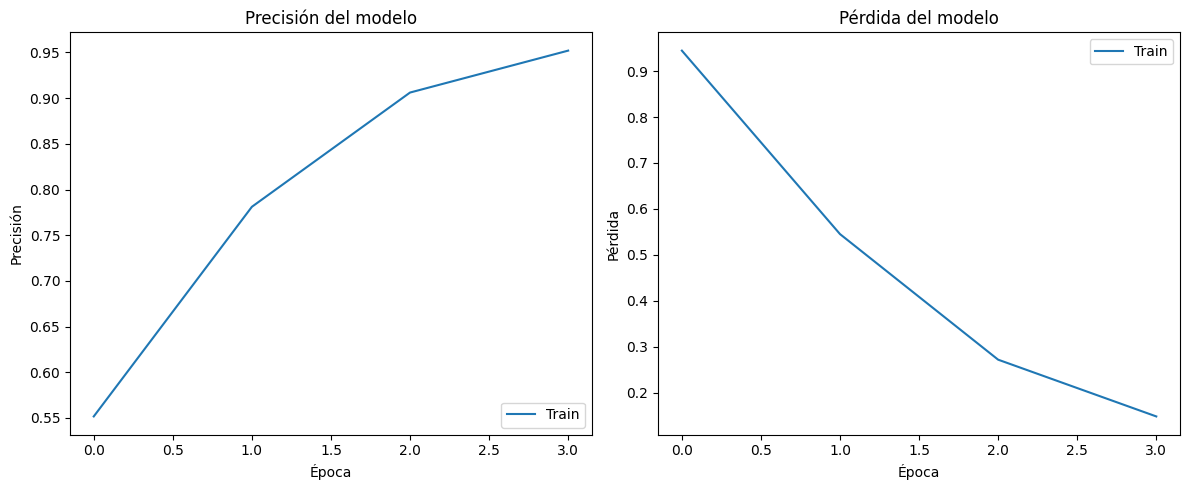


Proceso de grid search y entrenamiento completo.


In [6]:
# VISUALIZACIONES: Comparar rendimiento entre diferentes modelos


# 1. Gráfico de barras para los mejores modelos
plt.figure(figsize=(12, 6))
top_n = min(10, len(all_results_sorted))
top_models = results_df.head(top_n)['model_name'].tolist()
top_accs = results_df.head(top_n)['accuracy'].tolist()

# Colores basados en tipo de modelo
colors = []
for model_type in results_df.head(top_n)['model_type']:
    if model_type == 'simple_rnn':
        colors.append('blue')
    elif model_type == 'lstm':
        colors.append('green')
    else:  # gru
        colors.append('red')

# Gráfico
bars = plt.bar(top_models, top_accs, color=colors)
plt.xlabel('Modelo')
plt.ylabel('Accuracy')
plt.title('Top 10 Modelos por Accuracy')
plt.xticks(rotation=45, ha='right')

# Añadir valores sobre las barras
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
            f'{height:.3f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# 2. Comparar modelos con y sin BERT
plt.figure(figsize=(10, 6))
bert_avg = results_df[results_df['use_bert']]['accuracy'].mean()
no_bert_avg = results_df[~results_df['use_bert']]['accuracy'].mean()

bars = plt.bar(['Sin BERT', 'Con BERT'], [no_bert_avg, bert_avg], color=['lightblue', 'navy'])
plt.ylabel('Accuracy Promedio')
plt.title('Impacto de Embeddings BERT vs Tradicionales')

# Añadir valores sobre las barras
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
            f'{height:.3f}', ha='center', va='bottom', fontsize=10)

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# 3. Comparación por tipo de modelo y bidireccionalidad
plt.figure(figsize=(12, 5))

# Subgráfico 1: Comparación por tipo de modelo
plt.subplot(1, 2, 1)
model_type_perf = results_df.groupby('model_type')['accuracy'].mean()
bars1 = plt.bar(model_type_perf.index, model_type_perf.values, color=['blue', 'red', 'green'])
plt.title('Rendimiento por tipo de modelo')
plt.ylabel('Accuracy promedio')

# Añadir valores sobre las barras
for bar in bars1:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
            f'{height:.3f}', ha='center', va='bottom', fontsize=9)

plt.grid(axis='y', linestyle='--', alpha=0.7)

# Subgráfico 2: Comparación bidireccional vs unidireccional
plt.subplot(1, 2, 2)
bidir_perf = results_df.groupby('bidirectional')['accuracy'].mean()
bars2 = plt.bar(['Unidireccional', 'Bidireccional'], bidir_perf.values, color=['lightgray', 'darkgray'])
plt.title('Unidireccional vs Bidireccional')
plt.ylabel('Accuracy promedio')

# Añadir valores sobre las barras
for bar in bars2:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
            f'{height:.3f}', ha='center', va='bottom', fontsize=9)

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Entrenar el mejor modelo con configuración óptima
best_result = all_results_sorted[0]
print(f"\nMejor modelo: {best_result['model_name']}")
print(f"Accuracy: {best_result['accuracy']:.4f}")
print(f"F1-Score: {best_result['f1_score']:.4f}")

# Crear y entrenar el mejor modelo
print("\nEntrenando el mejor modelo con la configuración óptima...")
best_model = create_rnn_model(
    model_type=best_result['model_type'],
    bidirectional=best_result['bidirectional'],
    units=best_result['units'],
    learning_rate=best_result['learning_rate'],
    dropout_rate=0.3,
    use_bert=best_result['use_bert']
)

# Early stopping con un poco más de paciencia para el modelo final
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=3,
    restore_best_weights=True
)

# Entrenar modelo final
history = best_model.fit(
    X_train_pad,
    y_train,
    validation_data=(X_test_pad, y_test),
    epochs=10,  # Más épocas para el modelo final
    batch_size=best_result['batch_size'],
    callbacks=[early_stopping],
    verbose=1
)

# Evaluar modelo final
y_pred_probs = best_model.predict(X_test_pad)
y_pred = np.argmax(y_pred_probs, axis=1)

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=sorted(df['label'].unique()),
            yticklabels=sorted(df['label'].unique()))
plt.xlabel('Predicción')
plt.ylabel('Valor real')
plt.title('Matriz de Confusión del Mejor Modelo')
plt.show()

# Reporte de clasificación
print("\nReporte de clasificación del mejor modelo:")
print(classification_report(y_test, y_pred))

# Guardar el mejor modelo
model_filename = f'best_financial_sentiment_model_{best_result["model_type"]}.keras'
best_model.save(model_filename)
print(f"\nMejor modelo guardado como '{model_filename}'")

# Graficar el historial de entrenamiento
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.title('Precisión del modelo')
plt.ylabel('Precisión')
plt.xlabel('Época')
plt.legend(['Train'], loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.title('Pérdida del modelo')
plt.ylabel('Pérdida')
plt.xlabel('Época')
plt.legend(['Train'], loc='upper right')

plt.tight_layout()
plt.show()

print("\nProceso de grid search y entrenamiento completo.")